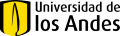

<span style="font-family:Cambria Math">
    
# Micro-proyecto 1. Generación de paleta de colores a partir de imágenes con técnicas de *machine learning* no supervisado

## Contexto
Este proyecto busca desarrollar una aplicación basada en *machine learning* que permita generar automáticamente paletas de colores a partir de imágenes. Esta herramienta ayudará a diseñadores, artistas y creadores de contenido a seleccionar combinaciones cromáticas armoniosas y funcionales de manera rápida y eficiente. La aplicación identificará los tonos dominantes y analizará sus relaciones cromáticas para crear paletas visualmente atractivas, optimizando la calidad y el impacto de la comunicación visual en diversos campos como el diseño, el arte, la psicología y el marketing.

***

También este micro-proyecto busca retar a los estudiantes para aplicar los conocimientos adquiridos en las semanas 1-4 del curso "*Machine Learning* No Supervisado".

***

## Objetivo
Desarrollar un método, basado en técnicas de agrupación, que permita extraer los tonos de
una imagen y generar un muestrario de los colores presentes en esta
</span>

***

<div class="alert alert-block alert-info">
<bNotar:</b >

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Núñez Campos para entrega el 24 de febrero.**
</div24></span>

***

<span style="font-family:Cambria Math">

## Desarrollo
Se empieza por el cargue de las librerias a usar y con la el *pipeline* para la preparación de los datos
</span>

In [1]:
from skimage import io, color
from skimage.transform import rescale
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage

Versiones de las librerías utilizadas TEST:

In [2]:
from importlib.metadata import version
version('scikit-image')
for library in ['scikit-image', 'matplotlib', 'numpy', 'scikit-learn', 'scipy']:
  print(library, ": ", version(library))

scikit-image :  0.25.1
matplotlib :  3.10.0
numpy :  2.2.1
scikit-learn :  1.6.0
scipy :  1.14.1


***

<span style="font-family:Cambria Math">
Para el cargue y preparación de los datos se eligió utilizar el espacio de color CIELAB. A continuación se explica con un poco más de detalle de qué se trata este modelo:
</span>

<span style="font-family:Cambria Math">

## Espacio de color CIELAB

El espacio de color CIELAB es un modelo cromático usado para describir todos los colores que puede percibir el ojo humano (`rojo`, `verde`, `azul` y `amarillo`) y tiene la intención de mimetizar la respuesta no lineal del sistema visual.

Este espacio de color utiliza tres dimensiones:
- Luminosidad `L*` (negro a blanco), con rango continuo `0:100`
- Eje verde-rojo `a*`, con rango continuo `-128:127`
- Eje azul-amarillo `a*`, con rango continuo `-128:127`
  
Entonces el cálculo de distancias euclidianas entre colores es válido en este espacio. (Por tal motivo no es necesario hacer escalamiento de datos?)

La función `color.rgb2lab` de la librería `skimage` permite transformar de un espacio de color RGB a uno CIELAB.
- El argumento `illuminant` puede ser “A”, “B”, “C”, “D50”, “D55”, “D65”, “D75”, “E”. `'D65'` es el valor por defecto.
- `color.rgb2lab` realiza la conversión entre RGB y CIELAB de forma segura, manejando los rangos apropiadamente

</span>

<span style="font-family:Cambria Math">
A continuación se muestra un ejemplo de como se realiza esta transformación:
</span>

In [3]:
rgb_test = np.array([100, 50, 125]).astype(np.uint8)
color.rgb2lab(rgb_test)
# Coincide con los resulados de http://colormine.org/convert/rgb-to-lab

array([ 30.57176673,  36.06177058, -33.60828633])

***

<span style="font-family:Cambria Math">

## Preprocesamiento

Para la construcción del pipeline de pre-procesamiento de los datos hay que considerar que estamos trabajando con imágenes. Por lo tanto, no se requiere de quitar *outlayers* y para el correcto funcionamiento de los modelos hay que tener datos escalados.

También es necesario re-escalar las imágenes, esto permite un mejor uso de los recursos de procesamiento ya que al final cada pixel se convertirá en un dato. Nos aseguramos de mantener el rango de colores original que es lo que más nos interesa para efecto de la construcción de la paleta de colores, y se realiza un "suavizado" durante el escalado ya que cuando se reduce el tamaño de una imagen, se pueden tener efectos no deseados como el aliasing (escalones o bordes dentados). Con el parámetro anti_aliasing=True aplica un filtro de suavizado Gaussiano antes del escalado, reduciendo estos defectos.

</span>

In [4]:
# Downsampling
def reescalar_img(img: np.ndarray, factor: float):
    img_rescaled = rescale(
        img,
        scale=factor,
        channel_axis=2, #especificar cuál es el canal de colores
        anti_aliasing=True, #suavizar durante el escalado
        preserve_range=True #mantener el rango de colores original
    )
    return img_rescaled.astype(img.dtype)

***
<span style="font-family:Cambria Math">

Se utiliza el comando `imread` de `skimage.io` para cargar la imagen y después de reescalarla se hace la transformación de la imágen para tenerla en formato RGB y CIELAB

</span>

In [5]:
# Cargar img reescalada en ambos espacios de color: RGB y LAB
def cargar_img_RGB_LAB_downsample(imgpath: str, factor: float = 0.25):
    rgb = io.imread(imgpath)
    rgb = reescalar_img(rgb, factor)
    lab = color.rgb2lab(rgb)
    return rgb, lab

***
<span style="font-family:Cambria Math">

También es necesario re-estructurar los datos para poder trabajar los pixeles como filas y los canales como columnas:

</span>

In [6]:
# Obtener data tabular: pixeles como filas y CIELAB como columnas
def img_to_tabular(img: np.ndarray):
    return img.reshape(-1, img.shape[-1])




***
<span style="font-family:Cambria Math">

## Clustering

Considerar esta métrica https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.deltaE_cie76

Para los modelos de agrupación se va a medir el *silhoutte score* de tres modelos: K-Medias (algoritmo basado en centroides), MeanShift (algoritmo híbrido),  Agrupación Aglomerativa (algoritmo jerárquico) y DBSCAN (algoritmo de densidad).

Se crean 4 funciones que nos permiten identificar los coeficientes de silueta de estos modelos pasando por un número de grupos entre 5 y 7 de acuerdo a las consideraciones del microproyecto (con excepción de MeanShift el cual no requiere como insumo el número de *clusters*).

</span>

In [7]:
# Selección de Kmeans con base en silhouette_score
def KMeans_silhouette(X: np.ndarray, Kmin: int = 5, Kmax: int = 7):

    modelos, silhouette_scores = np.array([]), np.array([])
    for k in range(Kmin, Kmax+1):
        modelo = KMeans(n_clusters=k, max_iter=300, n_init=10) #, n_jobs=-1)
        modelo.fit(X)
        modelos = np.append(modelos, modelo)
        silhouette_scores = np.append(silhouette_scores, silhouette_score(X, modelo.labels_))

    [print("Modelo KMeans K=", i+5, " --> Silhouette Score:", score) for (i,score) in enumerate(silhouette_scores)]

    mejor_modelo = modelos[silhouette_scores.argmax()]
    mejor_k = len(mejor_modelo.cluster_centers_)
    centroids_RGB_img = color.lab2rgb(mejor_modelo.cluster_centers_).reshape((1,mejor_k,3))

    return centroids_RGB_img

In [8]:
# Selección de MeanShift con base en silhouette_score
def MeanShift_silhouette(X: np.ndarray):

    modelos = np.array([])
    silhouette_scores = np.array([])

    bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=100)
    modelo = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs= -1)
    modelo.fit(X)
    n = modelo.cluster_centers_
    if n >= 1 :
      score = silhouette_score(X, modelo.labels_)
    else:
      score = -1

    print("Modelo MeanShift K=", n, " --> Silhouette Score:", score)

    k = len(modelo.cluster_centers_)
    centroids_RGB_img = color.lab2rgb(modelo.cluster_centers_).reshape((1,k,3))

    return centroids_RGB_img

In [9]:
# Selección de MeanShift con base en silhouette_score
def DBSCAN_silhouette(X: np.ndarray,  eps_list: list, min_samples_list: list, metric: str ='euclidian'):

    modelos = np.array([])
    silhouette_scores = np.array([])

    scores, eps_scores, min_samples_scores, num_clusters = [], [], [], []

    # Definimos la búsqueda exhaustiva con dos ciclos
    # El primero recorre todos los valores de épsilon
    for i in range(len(eps_list)):
        # Y el segundo recorre todos los valores de min_samples
        for j in range(len(min_samples_list)):
            eps_i = eps_list[i]
            min_samples_j = min_samples_list[j]
            eps_scores.append(eps_i)
            min_samples_scores.append(min_samples_j)
            # Definimos un modelo de DBSCAN con los valores actuales
            modelo_ij = DBSCAN(eps=eps_i, min_samples=min_samples_j, metric=metric, n_jobs=-1)
            # Entrenamos el modelo
            modelo_ij.fit(X)
            labels_ij = modelo_ij.labels_
            num_clusters_ij = len(set(labels_ij))
            num_clusters.append(num_clusters_ij)
            modelos.append(modelo_ij)
            # Almacenamos el coeficiente de la silueta
            # Si tenemos un número de clústeres mayor a 1, el coeficiente de la silueta está definido
            if num_clusters_ij > 1:
                score = silhouette_score(X, labels_ij)
                scores.append(score)
            # Si DBSCAN retorna un solo clúster, el coeficiente de la silueta no está definido
            else:
                scores.append(-1)

    [print("Modelo DBSCAN K=", num_clusters(i), " --> Silhouette Score:", scores(i)) for (i,score) in enumerate(silhouette_scores)]



    bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=100)
    modelo = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    modelo.fit(X)
    n = modelo.cluster_centers_
    score = silhouette_score(X, modelo.labels_)

    print("K=", n, " --> Silhouette Score:", score)

    k = len(modelo.cluster_centers_)
    centroids_RGB_img = color.lab2rgb(modelo.cluster_centers_).reshape((1,k,3))

    return centroids_RGB_img

## Paleta de colores + PCA + t-SNE

In [10]:
def generar_paleta(imgpath: str, factor:float = 0.05):
    rgb_1, lab_1 = cargar_img_RGB_LAB_downsample(imgpath, factor=factor)
    lab_1_tabular = img_to_tabular(lab_1)
    paleta = KMeans_silhouette(lab_1_tabular)

    # Imagen reescalada + Paleta
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(rgb_1)
    ax[1].imshow(paleta)

    print("Imagen reescalada a",str(rgb_1.shape[0])+"x"+str(rgb_1.shape[1]),"pixeles\n")

    # PCA
    #...

    # t-SNE
    #...

Modelo KMeans K= 5  --> Silhouette Score: 0.550816130029218
Modelo KMeans K= 6  --> Silhouette Score: 0.5735627153401281
Modelo KMeans K= 7  --> Silhouette Score: 0.5600657738462032
Imagen reescalada a 140x104 pixeles

CPU times: user 54.8 s, sys: 15 s, total: 1min 9s
Wall time: 10.1 s


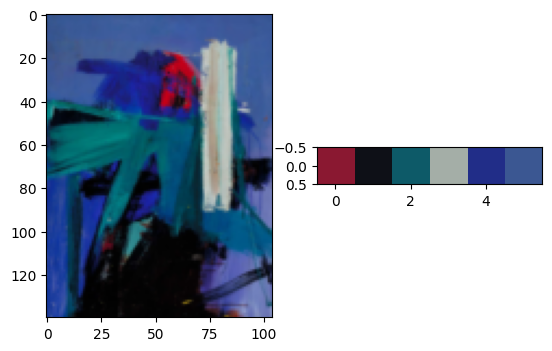

In [11]:
%time generar_paleta("img/franz-kline_blueberry-eyes-1960.jpg", factor=0.075)

Modelo KMeans K= 5  --> Silhouette Score: 0.6224083626670965
Modelo KMeans K= 6  --> Silhouette Score: 0.6325776088845833
Modelo KMeans K= 7  --> Silhouette Score: 0.5742955696154245
Imagen reescalada a 171x104 pixeles

CPU times: user 1min 5s, sys: 24.3 s, total: 1min 30s
Wall time: 12.7 s


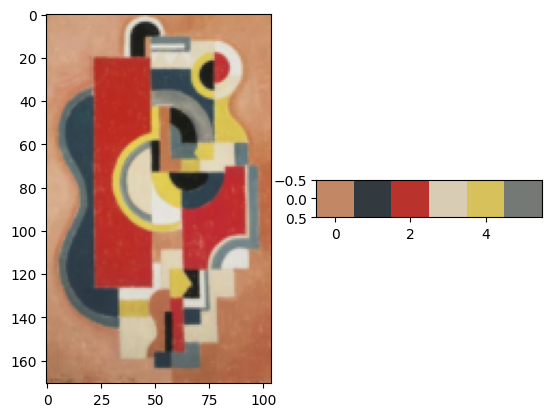

In [12]:
%time generar_paleta("img/adolf-fleischmann_hommage-delaunay-et-gleizes-1938.jpg", factor=0.075)

Modelo KMeans K= 5  --> Silhouette Score: 0.31714684584827835
Modelo KMeans K= 6  --> Silhouette Score: 0.30932616136458296
Modelo KMeans K= 7  --> Silhouette Score: 0.31136662130825316
Imagen reescalada a 104x129 pixeles

CPU times: user 54.2 s, sys: 8.35 s, total: 1min 2s
Wall time: 8.56 s


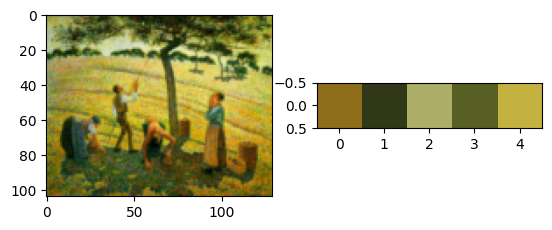

In [13]:
%time generar_paleta("img/camille-pissarro_apple-picking-at-eragny-sur-epte-1888.jpg", factor=0.075)

Modelo KMeans K= 5  --> Silhouette Score: 0.39887564248337315
Modelo KMeans K= 6  --> Silhouette Score: 0.409320771726097
Modelo KMeans K= 7  --> Silhouette Score: 0.38738133364623756
Imagen reescalada a 104x139 pixeles

CPU times: user 56.8 s, sys: 14.7 s, total: 1min 11s
Wall time: 9.58 s


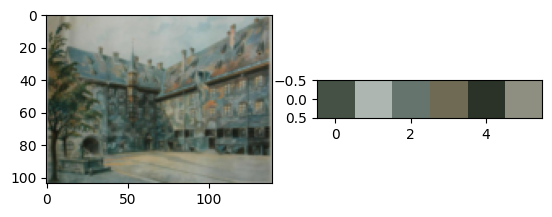

In [14]:
%time generar_paleta("img/adolf-hitler_the-courtyard-of-the-old-residency-in-munich-1913.jpg", factor=0.075)

# Referencias

---
- https://en.wikipedia.org/wiki/CIELAB_color_space#Perceptual_differences
- https://es.wikipedia.org/wiki/Espacio_de_color_Lab
- https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.rgb2lab
- https://stackoverflow.com/questions/52459146/what-should-be-the-input-to-skimage-color-rgb2lab